In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression

pd.set_option("display.max_columns", None)

In [2]:
# Load data
df = pd.read_csv("Salary_Data.csv")

# Add numbering 1 to 500
df = df.reset_index()
df.index = df.index + 1
df.index.name = "S.No"

# Display all rows
pd.set_option('display.max_rows', None)
df

,index,Job Title,Experience (Years),Education Level,Location,Company Size,Employment Type,Work Mode,Salary (INR)
S.No,,,,,,,,,
1,0,System Analyst,7.8,High School,Mumbai,Small,Full-Time,Onsite,726637
2,1,Machine Learning Engineer,12.5,Master's,Pune,Medium,Intern,Remote,1321536
3,2,Web Developer,5.1,PhD,Bangalore,Large,Full-Time,Hybrid,1581120
4,3,Machine Learning Engineer,13.5,High School,Hyderabad,Large,Intern,Onsite,1087725
5,4,Machine Learning Engineer,6.1,PhD,Delhi,Small,Contract,Onsite,1374000
6,5,Data Scientist,0.7,Bachelor's,Hyderabad,Large,Contract,Hybrid,764085
7,6,Web Developer,13.6,Bachelor's,Pune,Medium,Intern,Hybrid,1080600
8,7,Web Developer,1.8,High School,Delhi,Medium,Full-Time,Onsite,383000
9,8,Web Developer,5.1,Master's,Pune,Small,Contract,Remote,918360


In [3]:
target_col = "Salary (INR)"   # Change if your target name is different
X = df.drop(columns=[target_col])
y = df[target_col]

numeric_features = [c for c in X.columns if df[c].dtype != 'object']
categorical_features = [c for c in X.columns if df[c].dtype == 'object']

In [4]:
numeric_preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_preprocess, numeric_features),
    ("cat", categorical_preprocess, categorical_features)
])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
models = {
    "LinearRegression": Pipeline([("prep", preprocess), ("model", LinearRegression())]),
    "RandomForest": Pipeline([("prep", preprocess), ("model", RandomForestRegressor(n_estimators=300, random_state=42))]),
    "GradientBoosting": Pipeline([("prep", preprocess), ("model", GradientBoostingRegressor(random_state=42))])
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    R2 = r2_score(y_test, pred)
    results.append((name, R2))

results

[('LinearRegression', 0.9578962586961032),
 ('RandomForest', 0.897056712814626),
 ('GradientBoosting', 0.9654775048088252)]

In [7]:
voting = Pipeline([
    ("prep", preprocess),
    ("model", VotingRegressor([
        ("rf", RandomForestRegressor(n_estimators=300, random_state=42)),
        ("gb", GradientBoostingRegressor(random_state=42))
    ]))
])

voting.fit(X_train, y_train)
voting_pred = voting.predict(X_test)
print("Voting Model R2 Score:", r2_score(y_test, voting_pred))

Voting Model R2 Score: 0.9425632586569751


In [8]:
import pickle
pickle.dump(voting, open("salary_best_model.pkl", "wb"))
print("Saved model as salary_best_model.pkl")

Saved model as salary_best_model.pkl


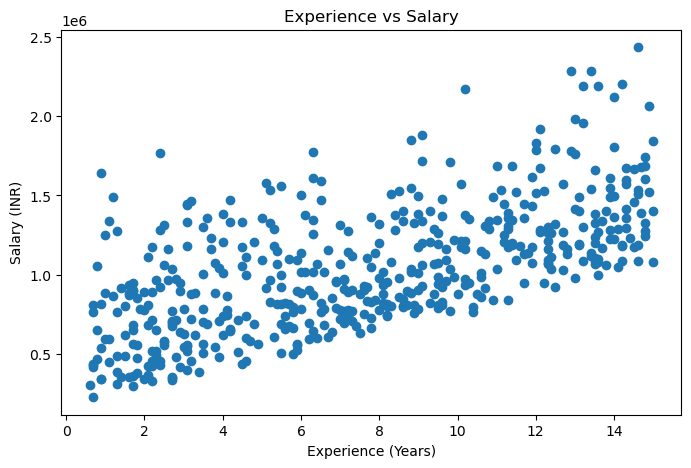

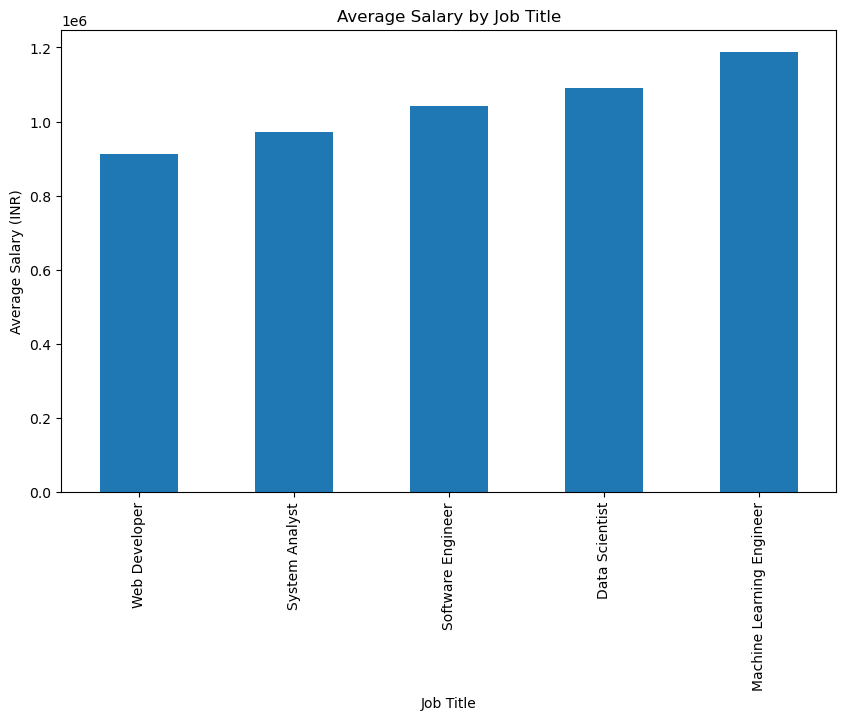

In [9]:
# Scatter Plot
plt.figure(figsize=(8,5))
plt.scatter(df['Experience (Years)'], df['Salary (INR)'])
plt.xlabel("Experience (Years)")
plt.ylabel("Salary (INR)")
plt.title("Experience vs Salary")
plt.show()

# Bar Chart of Average Salary by Job Title
salary_by_job = df.groupby('Job Title')['Salary (INR)'].mean().sort_values()

plt.figure(figsize=(10,6))
salary_by_job.plot(kind='bar')
plt.xlabel("Job Title")
plt.ylabel("Average Salary (INR)")
plt.title("Average Salary by Job Title")
plt.show()

In [10]:
predict_script = '''\
import pickle
import pandas as pd

model_path = "salary_best_model.pkl"
data_path = "one_row_example.csv"  # Change to your input CSV

with open(model_path, "rb") as f:
    model = pickle.load(f)

new_data = pd.read_csv(data_path)
prediction = model.predict(new_data)

print("Predicted Salary:", float(prediction[0]))
'''

with open("predict_one_row.py", "w") as f:
    f.write(predict_script)

print("predict_one_row.py created successfully")

predict_one_row.py created successfully
